# Applied Machine learning !

In this lab we will study a soccer dataset and apply Machine Learning to it. We will try to predict the skin color of a player given some of it's information.

### Some useful imports

In [248]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pylab
import datetime
from sklearn import metrics
from sklearn.preprocessing import binarize, normalize, LabelEncoder
from sklearn.model_selection import cross_val_score, KFold, train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier as RFC
from helpers import *
from scipy.stats import uniform
pylab.rcParams['figure.figsize'] = (16, 6)
np.random.seed(0)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### First we import the dataset and study it :

In [2]:
df = pd.read_csv("./CrowdstormingDataJuly1st.csv")

How much data do we have ?

In [3]:
df.shape

(146028, 28)

Let's look at our columns.

In [4]:
df.head().ix[:,:13]

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,ties,defeats,goals
0,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,0,0,1,0
1,john-utaka,John Utaka,Montpellier HSC,France,08.01.1982,179.0,82.0,Right Winger,1,0,0,1,0
2,abdon-prats,Abdón Prats,RCD Mallorca,Spain,17.12.1992,181.0,79.0,NaN,1,0,1,0,0
3,pablo-mari,Pablo Marí,RCD Mallorca,Spain,31.08.1993,191.0,87.0,Center Back,1,1,0,0,0
4,ruben-pena,Rubén Peña,Real Valladolid,Spain,18.07.1991,172.0,70.0,Right Midfielder,1,1,0,0,0


In [5]:
df.head().ix[:,13:]

,yellowCards,yellowReds,redCards,photoID,rater1,rater2,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
0,0,0,0,95212.jpg,0.25,0.50,1,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696
1,1,0,0,1663.jpg,0.75,0.75,2,2,ZMB,0.203375,40.0,0.010875,-0.204082,49.0,0.061504
2,1,0,0,NaN,NaN,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
3,0,0,0,NaN,NaN,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
4,0,0,0,NaN,NaN,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002


There are two different skin-color (from white to black) raters, that agree on percentage:

In [6]:
np.count_nonzero(df.rater1 == df.rater2) / len(df)

0.6554496397951078

Thanks to the previous [work](http://nbviewer.jupyter.org/github/mathewzilla/redcard/blob/master/Crowdstorming_visualisation.ipynb) of Mat Evans and Tom Stafford and their team. We know some of the specificities of the data, namely:
- We learn that the data is organized in a player-referee pairs (dyads). Each row has all the interaction with one player and a referee. For their analysis they decided to separate this dataset for each interaction between a player and a referee. Our approach will rather group by player short to keep the player granularity as central point.
- The data about skin color is not consistent between the two raters and the picture might be missing. We decided to remove the data with no picture as it cannot help to answer "given a soccer player description outputs his skin color". There are different ways to attribute skin color to each player :
    - mean of the two raters
    - keep only the dyads which have the same score for r1 and r2
    - train on both raters and compare the result
- The raters data in the set [0, 0.25, 0.50, 0.75, 1] to classify "correctly" there are 3 possibilities :
    - first one is to have a class for each number
    - second is to have two classes with a cut at 0.5 (we have to define which class contain 0.5)
    - third is to have 3 classes : $<0.5$, $0.5$, $>0.5$
- Finally we learn that there are dyads which are not really part of the 2012-2013 data but from past matches in the carrer of the player. Either remove thoses entires because their not really part of the dataset "topic" or let them as their could give more insights. We decided to remove them.

Here is how we think of organizing this homework :
- First we will clean a bit the data
- Then we will aggregate the data per player
- Then we will for each point made above with multiple proposition see which one is the best, if multiple ones seem good we will keep them and test them with cross validation.
- Finally we will find the best result we can with all possible datasets with a random forest classifier.

## Removing non valid dyads from player past history

To remove those dyad, the logic is to say that if a referee has participated in at least one match in the league he should have at least 22 appearances in the dataset.

In [7]:
dyads_b = df.shape[0]
games_b = df.games.sum()
referee_b = df.refNum.unique().shape[0]
print("number of dyads before cleaning : ", dyads_b)
print("number of matches before cleaning : ", games_b)
print("number of unique referee before cleaning : ", referee_b)

number of dyads before cleaning :  146028
number of matches before cleaning :  426572
number of unique referee before cleaning :  3147


Using cited work number for comparison, after cleaning they got:

In [8]:
games_a_tot = 415692
dyads_a_tot = 137635
referee_a_tot = 1261

Our method (group by player short):

In [9]:
apearances_once_player = df.refNum.value_counts()
len(apearances_once_player)

3147

In [10]:
apearances_sup21_once_player = apearances_once_player[apearances_once_player >= 22]
df_sup21_once_player = df[df["refNum"].isin(apearances_sup21_once_player.index.values)]

In [11]:
dyads_a_once_player = df_sup21_once_player.shape[0]
games_a_once_player = df_sup21_once_player.games.sum()
referee_a_once_player = df_sup21_once_player["refNum"].unique().shape[0]
print("number of dyads after removing : ", dyads_a_once_player)
print("number of matches after removing : ", games_a_once_player) # a bit lower than before again
print("number of unique referee after removing : ", referee_a_once_player)

number of dyads after removing :  133501
number of matches after removing :  406924
number of unique referee after removing :  998


Let's show how much data we lose

In [12]:
print("loss of games with their method :", games_a_tot / games_b)
print("loss of dyads with their method :", dyads_a_tot / dyads_b)
print("loss of refs with their method : ", referee_a_tot / referee_b)

loss of games with their method : 0.974494340932
loss of dyads with their method : 0.9425247212863287
loss of refs with their method :  0.40069907848744835


In [13]:
print("loss of games with our method :", games_a_once_player / games_b)
print("loss of dyads with our method :", dyads_a_once_player / dyads_b)
print("loss of refs with our method : ", referee_a_once_player / referee_b)

loss of games with our method : 0.953939780389
loss of dyads with our method : 0.914215082039061
loss of refs with our method :  0.3171274229424849


We lost a bit more data but it will be more convient to use later. Let's check using the same kind of occurences graph.

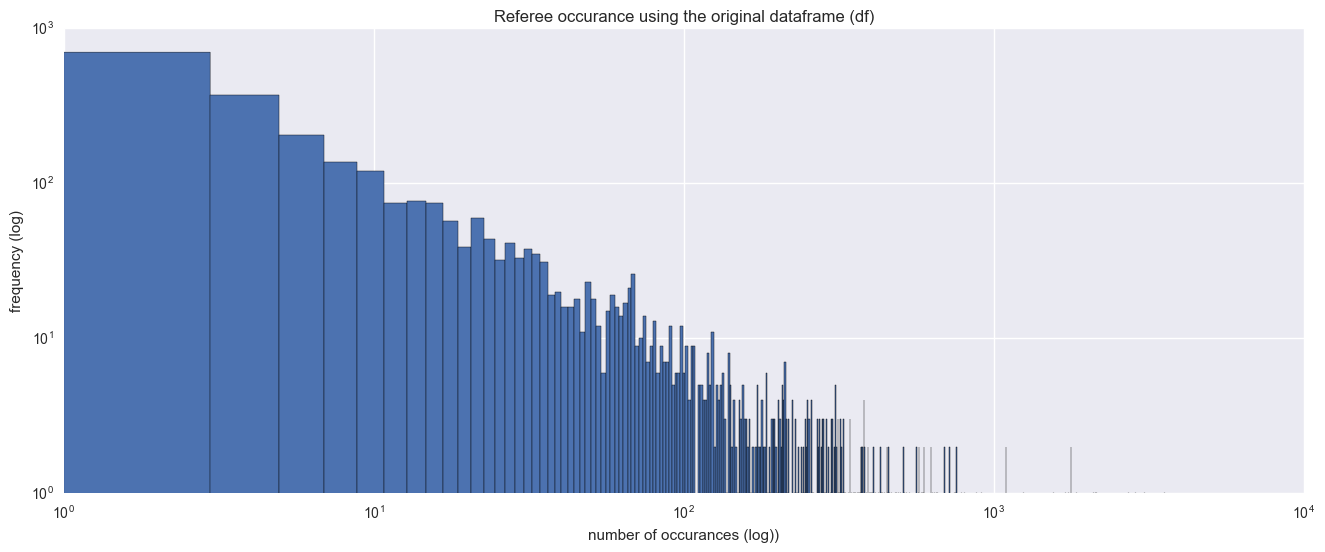

In [14]:
plt.hist(df[["refNum", "games"]].groupby("refNum").sum().games.tolist(), referee_b-11)
plt.xscale('log')
plt.xlabel('number of occurances (log))')
plt.yscale('log')
plt.ylabel('frequency (log)')
plt.title("Referee occurance using the original dataframe (df)")
plt.show()

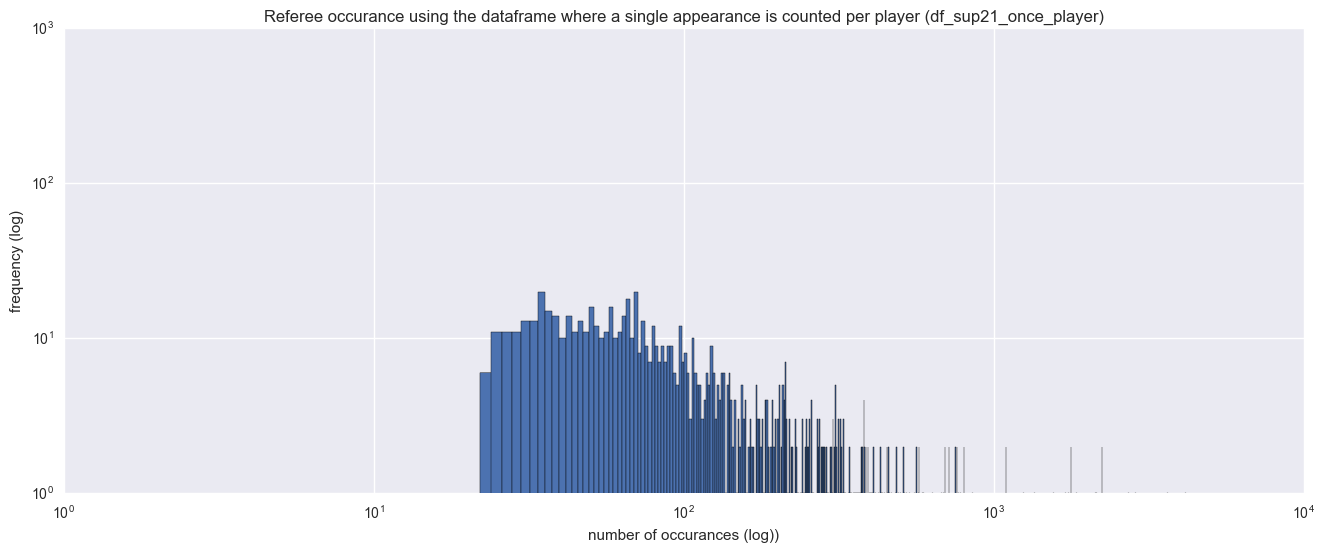

In [93]:
plt.hist(df_sup21_once_player[["refNum", "games"]].groupby("refNum").sum().games.tolist(), referee_b-11)
plt.xscale('log')
plt.xlim([1,10000])
plt.xlabel('number of occurances (log))')
plt.yscale('log')
plt.ylim([0,1000])
plt.ylabel('frequency (log)')
plt.title("Referee occurance using the dataframe where a single appearance is counted per player (df_sup21_once_player)")
plt.show()

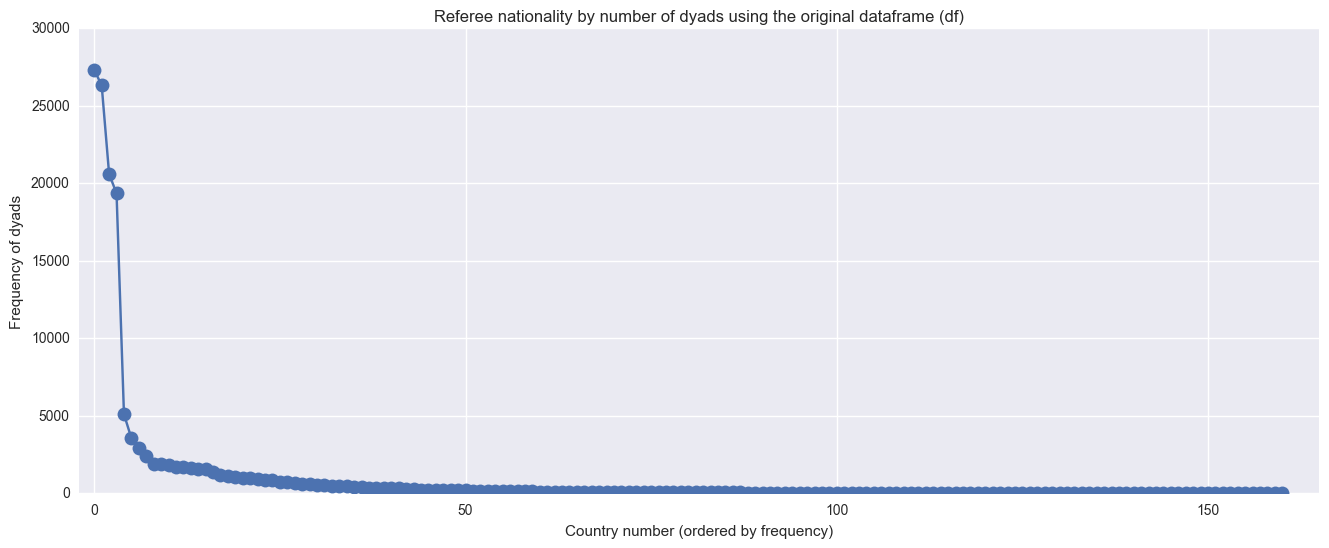

In [94]:
x = df.refCountry.value_counts()
lines = plt.plot(x.values, marker='.', ms=20)
plt.title('Referee nationality by number of dyads using the original dataframe (df)')
plt.xlabel('Country number (ordered by frequency)')
plt.xlim([-2,165])
plt.ylabel('Frequency of dyads')
plt.show()

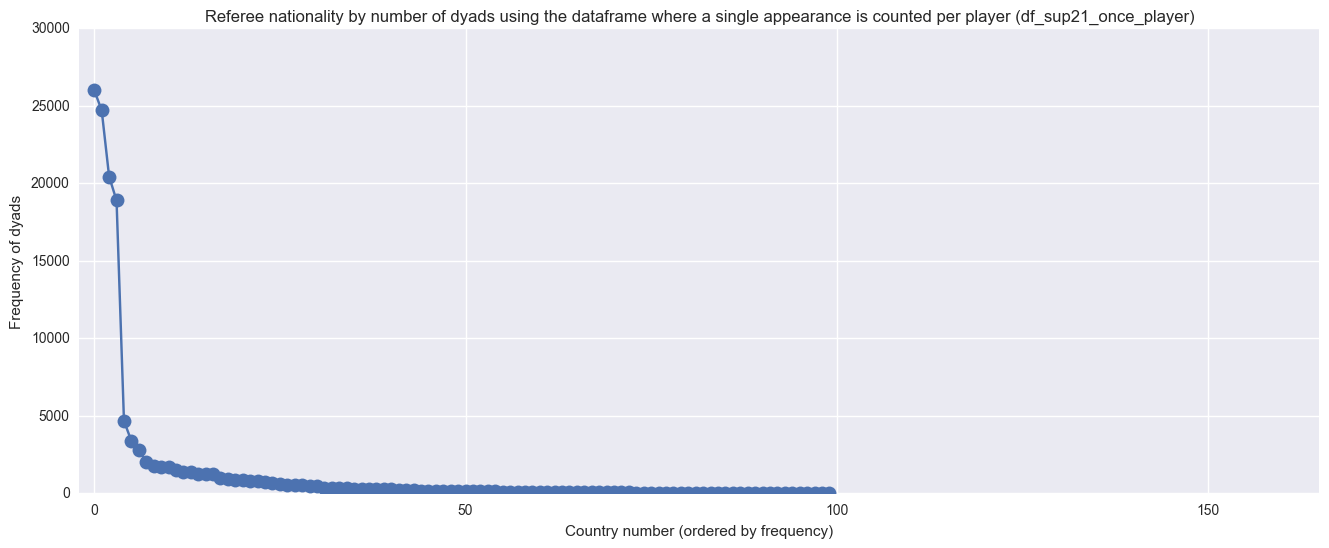

In [95]:
x = df_sup21_once_player.refCountry.value_counts()
lines = plt.plot(x.values, marker='.', ms=20)
plt.title('Referee nationality by number of dyads using the dataframe where a single appearance is counted per player (df_sup21_once_player)')
plt.xlabel('Country number (ordered by frequency)')
plt.xlim([-2,165])
plt.ylabel('Frequency of dyads')
plt.show()

Here we see that our method reduces the number of total countries but doesn't change the frequency of dyads with the most represented countries compared to the previous graph.

## Removing non usable data for our ML algorithm

We know sometimes there is no images for a player and therefor no skin color rating. Therefore we remove them.

In [18]:
df_with_pic = df_sup21_once_player[df_sup21_once_player["photoID"].notnull()]

In [19]:
df_sup21_once_player.shape[0]

133501

In [20]:
df_with_pic.shape[0]

113862

Should be all clean now.

In [21]:
dfc = df_with_pic

## Aggregating the data by player

Let's look at a single players dyad to have an idea of what it looks like

In [107]:
groups = dfc.groupby("playerShort")

In [108]:
lucas = groups.get_group("lucas-wilchez")

In [109]:
lucas.head().ix[:,:13]

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,ties,defeats,goals
2782,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,3,1,1,1,0
3384,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,0,0,1,0
5692,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,1,0,0,0
9058,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,2,2,0,0,0
14886,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,0,1,0,0


In [110]:
lucas.head().ix[:,13:]

,yellowCards,yellowReds,redCards,photoID,rater1,rater2,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
2782,0,0,0,95212.jpg,0.25,0.5,88,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
3384,0,0,0,95212.jpg,0.25,0.5,94,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
5692,0,0,0,95212.jpg,0.25,0.5,137,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
9058,1,0,0,95212.jpg,0.25,0.5,214,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696
14886,0,0,0,95212.jpg,0.25,0.5,313,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696


First we will only keep the columns that seem relevant to us and remove the ones we think are not important :
- `player` which is a repetition of the playershort
- `photoID` which is 1-to-1 with the player
- referee related attibutes which cannot be aggregated (`refNum`, `refCountry`, `Alpha3`)
- `nIAT` and `nExp` really not relevant here we could do a weihted mean with the "mean" and "se" columns but it seemed a bit exagerated (futur improvement ?)
    
Why we kept other columns is explained below with the aggregation operation.

In [211]:
df_byshort = dfc.groupby("playerShort")
df_grouped = df_byshort.agg({
        "club": lambda x: x.unique()[0],
        "leagueCountry": lambda x: x.unique()[0],
        "birthday": lambda x: x.unique()[0],
        "height": np.max,
        "weight": np.max,
        "position": lambda x: x.unique()[0],
        "games": np.sum,
        "victories": np.sum,
        "ties": np.sum,
        "defeats": np.sum,
        "goals": np.sum,
        "yellowCards": np.sum,
        "yellowReds": np.sum,
        "redCards": np.sum,
        "rater1": np.max, # never changes so we can take either min, max or mean 
        "rater2": np.max, # same here (we used this to test that nothing changed : [np.min, np.max, np,mean])
        "meanIAT": np.mean, # Here doing the mean seems a bit confusing but it will give an 
        "seIAT": np.mean,   # indicatiion whether the player could have been mistreated in 
                            # some of his matches or never.
        "meanExp": np.mean, # Same here
        "seExp": np.mean    # We could have applied pooled variance (will see later) : https://en.wikipedia.org/wiki/Pooled_variance
    })

In [212]:
# We used this to check wether min and max rating change for each player (which was not the case)
np.count_nonzero(df_byshort.agg({"rater1": np.min}) != df_byshort.agg({"rater1": np.max}))

0

In [213]:
np.count_nonzero(df_byshort.agg({"rater2": np.min}) != df_byshort.agg({"rater2": np.max}))

0

In [214]:
np.count_nonzero(df_byshort.agg({"position": lambda x: x.unique().shape[0]}) > 1)

0

In [215]:
np.count_nonzero(df_byshort.agg({"leagueCountry": lambda x: x.unique().shape[0]}) > 1)

0

In [216]:
np.count_nonzero(df_byshort.agg({"club": lambda x: x.unique().shape[0]}) > 1)

0

In [217]:
np.count_nonzero(df_byshort.agg({"birthday": lambda x: x.unique().shape[0]}) > 1)

0

In [218]:
df_grouped.head().ix[:,:13]

,rater2,meanExp,position,meanIAT,leagueCountry,club,seIAT,yellowCards,birthday,weight,games,goals,ties
playerShort,,,,,,,,,,,,,
aaron-hughes,0.00,0.487879,Center Back,0.344759,England,Fulham FC,0.000333,19,08.11.1979,71.0,641,9,176
aaron-hunt,0.25,0.453989,Attacking Midfielder,0.349332,Germany,Werder Bremen,0.000226,39,04.09.1986,73.0,329,59,70
aaron-lennon,0.25,0.491482,Right Midfielder,0.345893,England,Tottenham Hotspur,0.000367,11,16.04.1987,63.0,412,31,97
aaron-ramsey,0.00,0.511650,Center Midfielder,0.346790,England,Arsenal FC,0.000525,31,26.12.1990,76.0,254,39,42
abdelhamid-el-kaoutari,0.25,0.335587,Center Back,0.331600,France,Montpellier HSC,0.001488,8,17.03.1990,73.0,124,1,40


In [219]:
df_grouped.head().ix[:,13:]

,height,defeats,yellowReds,rater1,victories,redCards,seExp
playerShort,,,,,,,
aaron-hughes,182.0,222,0,0.25,243,0,0.001553
aaron-hunt,183.0,119,0,0.00,140,1,0.001025
aaron-lennon,165.0,115,0,0.25,200,0,0.002032
aaron-ramsey,178.0,67,0,0.00,145,1,0.002938
abdelhamid-el-kaoutari,180.0,43,4,0.25,41,2,0.005296


In [220]:
len(df_grouped)

1584

Thanks to the description of the data in DATA.md we know there should be 1586 players with pictures.
With this value we can validate the fact that we lost minimal data and have most of the players with a picture.

## Preparing Data

As a last step before starting to do machine learning we need to reformat the data and seperate it

First we need to make rows which contain strings in integers (club, position, leagueCountry)

In [221]:
df_grouped["club"] = df_grouped["club"].astype(np.str)
df_grouped["position"] = df_grouped["position"].astype(np.str)
df_grouped["leagueCountry"] = df_grouped["leagueCountry"].astype(np.str)

def encodeLabels(col, df):
    le = LabelEncoder()
    le.fit(df[col].unique())
    df[col] = le.transform(df[col])

encodeLabels("club", df_grouped)
encodeLabels("position", df_grouped)
encodeLabels("leagueCountry", df_grouped)

In [222]:
today = datetime.datetime.now()
df_grouped.birthday = df_grouped.birthday.apply(lambda x : float((today - pd.to_datetime(x)).days))

Now we can create the futur x and y for training

In [223]:
y_possible = df_grouped[["rater1","rater2"]]
y_possible.head()

,rater1,rater2
playerShort,,
aaron-hughes,0.25,0.00
aaron-hunt,0.00,0.25
aaron-lennon,0.25,0.25
aaron-ramsey,0.00,0.00
abdelhamid-el-kaoutari,0.25,0.25


In [224]:
x = df_grouped.drop(y_possible, axis=1)
x.head().ix[:,:13]

,meanExp,position,meanIAT,leagueCountry,club,seIAT,yellowCards,birthday,weight,games,goals,ties,height
playerShort,,,,,,,,,,,,,
aaron-hughes,0.487879,1,0.344759,0,34,0.000333,19,13618.0,71.0,641,9,176,182.0
aaron-hunt,0.453989,0,0.349332,2,90,0.000226,39,11185.0,73.0,329,59,70,183.0
aaron-lennon,0.491482,10,0.345893,0,82,0.000367,11,10813.0,63.0,412,31,97,165.0
aaron-ramsey,0.511650,3,0.346790,0,6,0.000525,31,9463.0,76.0,254,39,42,178.0
abdelhamid-el-kaoutari,0.335587,1,0.331600,1,51,0.001488,8,9747.0,73.0,124,1,40,180.0


In [225]:
x.head().ix[:,13:]

,defeats,yellowReds,victories,redCards,seExp
playerShort,,,,,
aaron-hughes,222,0,243,0,0.001553
aaron-hunt,119,0,140,1,0.001025
aaron-lennon,115,0,200,0,0.002032
aaron-ramsey,67,0,145,1,0.002938
abdelhamid-el-kaoutari,43,4,41,2,0.005296


In [226]:
for feature, col in x.iteritems():
        has_nan = True in col.isnull().unique()
        if has_nan:
            x[feature] = col.fillna(int(col.mean()))

## Naive machine learning

In [250]:
rfc = RFC(n_estimators=10, n_jobs=-1, class_weight=None)

Let's build y (in a naive fashion for now) and use sklearn normalizer with the y's.

In [251]:
y = ((y_possible['rater1'] + y_possible['rater2']) / 2 < 0.5).values

In [252]:
normalizer = Normalizer()
for feature, col in x.iteritems():
    x[feature] = normalizer.fit_transform(col.reshape(-1,len(col)), y).T

In [253]:
rfc.fit(x, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=-1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [254]:
y_pred = rfc.predict(x)

In [255]:
print(metrics.mean_absolute_error(y, y_pred))
print(metrics.accuracy_score(y, y_pred))

0.00631313131313
0.993686868687


/usr/local/lib/python3.5/site-packages/sklearn/metrics/regression.py:164: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.
  output_errors = np.average(np.abs(y_pred - y_true),


Overfitting seems to be high without validating.

## Correct validation

Let's first split the dataset into a training and testing set. This seems to be generally a good practice in machine learning :).

In [256]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=4)

In [257]:
rfc = RFC(n_estimators=10, class_weight=None)

In [258]:
rfc.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [259]:
y_pred = rfc.predict(x_test)

In [262]:
print(metrics.mean_absolute_error(y_test, y_pred))
print(metrics.accuracy_score(y_test, y_pred))

0.242902208202
0.757097791798


/usr/local/lib/python3.5/site-packages/sklearn/metrics/regression.py:164: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.
  output_errors = np.average(np.abs(y_pred - y_true),


Ok that's kind of disapointing... (but not so much suprising). A better way to show the error is cross validation.

In [263]:
# Cross validation 10-Fold (for now) with accuracy scoring
scores = cross_val_score(rfc, x, y, cv=10, scoring='accuracy')

In [264]:
def show_score(scores):
    print(scores)
    print("--------------------------")
    print("mean :", np.mean(scores))
    print("min :", np.min(scores))
    print("max :", np.max(scores))

show_score(scores)

[ 0.74213836  0.81761006  0.73584906  0.70440252  0.78616352  0.7721519
  0.7721519   0.7721519   0.75949367  0.78980892]
--------------------------
mean : 0.76519218063
min : 0.704402515723
max : 0.817610062893


We can see again that the result is not pretty, the mean result we have is ~76% which is not much better than perdicting that all players are light skinned.

Proportions of classes for the mean rating (considering 1 -> $mean \leq 0.5$).

In [265]:
# Proportion of light and dark skinned players
prop_1 = np.sum(y) / len(y)
prop_0 = 1 - prop_1
print("proportion of ones :", prop_1)
print("proportion of zeroes :", prop_0)

proportion of ones : 0.756944444444
proportion of zeroes : 0.243055555556


Let's look at what the confusion matrix has to say.

In [266]:
confusion_mx = metrics.confusion_matrix(y_test, y_pred)
TP = confusion_mx[1, 1]
TN = confusion_mx[0, 0]
FP = confusion_mx[0, 1]
FN = confusion_mx[1, 0]

In [267]:
confusion_mx

array([[ 24,  52],
       [ 25, 216]])

Depending on the tree we got approximatively:

|total : 317| pred : 0 |  pred : 1  |
|---|----|-----|
| actual : 0 | TN = 24 | FP = 52 |
| actual : 1 | FN = 25 | TP = 216 |

We can see here that we are good at predicting ones, but our predictions of 0 are all over the place.

There is an easy way to show this : the **Specificity** (or how correct is the classifier with 0 values)

In [281]:
specificity = TN / float(TN + FP)
print("Specificity :", specificity)

## cross validation version.
def specificity(y, y_pred, **kwargs):
    confusion_mx = metrics.confusion_matrix(y, y_pred)
    TP = confusion_mx[1, 1]
    TN = confusion_mx[0, 0]
    FP = confusion_mx[0, 1]
    FN = confusion_mx[1, 0]
    
    specificity = TN / float(TN + FP)
    return specificity

specificity_scorer = metrics.make_scorer(specificity)

specificity = cross_val_score(rfc, x, y, cv=20, scoring=specificity_scorer)
print("Cross validated specificity :", np.mean(specificity))

Specificity : 0.315789473684
Cross validated specificity : 0.414868421053


We can compare it to **Sensitivity** (or true positive rate)

In [284]:
sensitivity = TP / float(TP + FN)
print("Sensitivity :", sensitivity)

## cross validation version
recall = cross_val_score(rfc, x, y, cv=20, scoring='recall')
print("Cross validated sensitivity or recall :", np.mean(recall))

Sensitivity : 0.896265560166
Cross validated sensitivity or recall : 0.87406779661


Which is much better. 

All these methods are taken from the course and inspired from this [notebook](http://nbviewer.jupyter.org/github/justmarkham/scikit-learn-videos/blob/master/09_classification_metrics.ipynb).

So, how are we going to do a better job ?

The first thing we realize is that there is a way to indicate to the random forest classifier the fact that there is a disparity within the data.

In [285]:
class_weights = {
    1 : prop_1,
    0 : prop_0
}

In [286]:
rfc = RFC(n_estimators=10, n_jobs=-1, class_weight=class_weights)

We will use a function that prints out most of the information we used above to test our new rfc 

In [287]:
from helpers import test_rfc
test_rfc(rfc, x, y)

Cross validation scores
[ 0.76656151  0.73817035  0.76340694  0.74763407  0.78481013]
--------------------------
cross mean : 0.760116599449
cross min : 0.738170347003
cross max : 0.784810126582
----------
TP : 215
TN : 26
FP : 50
FN : 26
----------
specificity : 0.41
sensitivity or recall : 0.873234463277


Ok, to bad it's not really an improvement.

Let's try something else : changing the classification threshold

We think this will help the **specificity** get higher.

Let's retrain our data with our new rfc (with weights)

In [288]:
rfc.fit(x_train, y_train)
y_pred = rfc.predict(x_test)

Getting the probability of ones of the classifier

In [289]:
y_pred_prob = rfc.predict_proba(x_test)[:, 1]

Separating the probability of true and false values

In [290]:
y_pred_prob1 = [x[1] for x in zip(y_test, y_pred_prob) if x[0]]
y_pred_prob0 = [x[1] for x in zip(y_test, y_pred_prob) if not x[0]]

The following graph was inspired by this video :

https://www.youtube.com/watch?v=OAl6eAyP-yo

It shows in blue the probability given to the true 0 values and in red the probability of true 1 values.

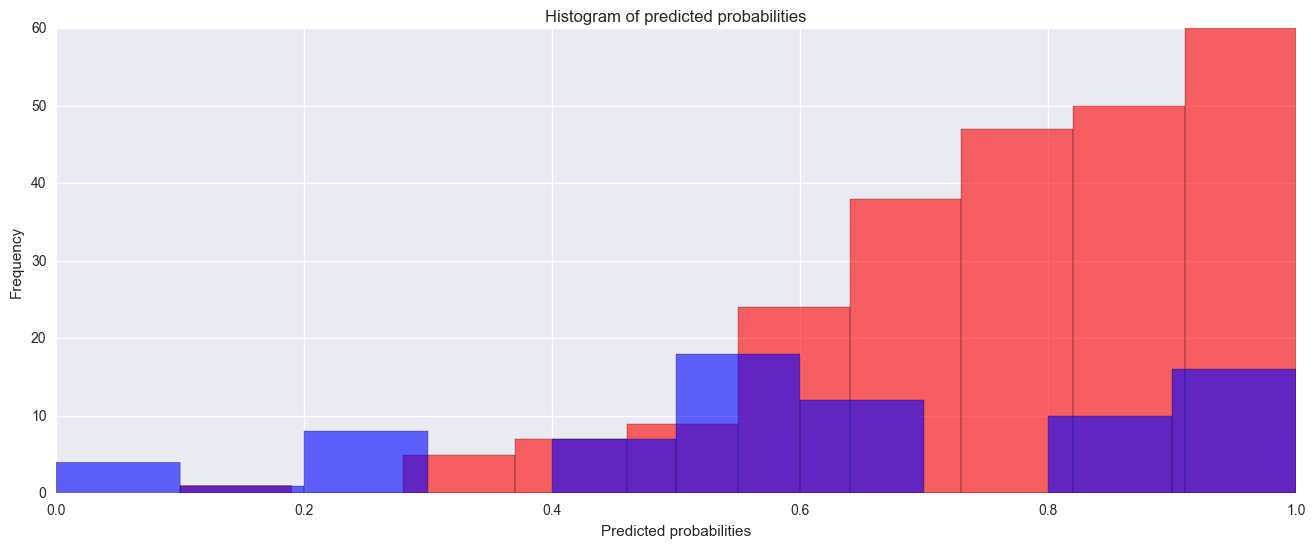

In [291]:
# histogram of predicted probabilities
plt.hist(y_pred_prob1, bins=10, alpha=0.6, color="red")
plt.hist(y_pred_prob0, bins=10, alpha=0.6, color="blue")
plt.xlim(0, 1)
plt.title('Histogram of predicted probabilities')
plt.xlabel('Predicted probabilities')
plt.ylabel('Frequency')

With this graph we realized that it's going to be very difficult to have a good and fair (in terms of specificity and sensitivity) 

To verify this fact we are going to use the ROC curve and the AUC (Area Under the Curve) metric

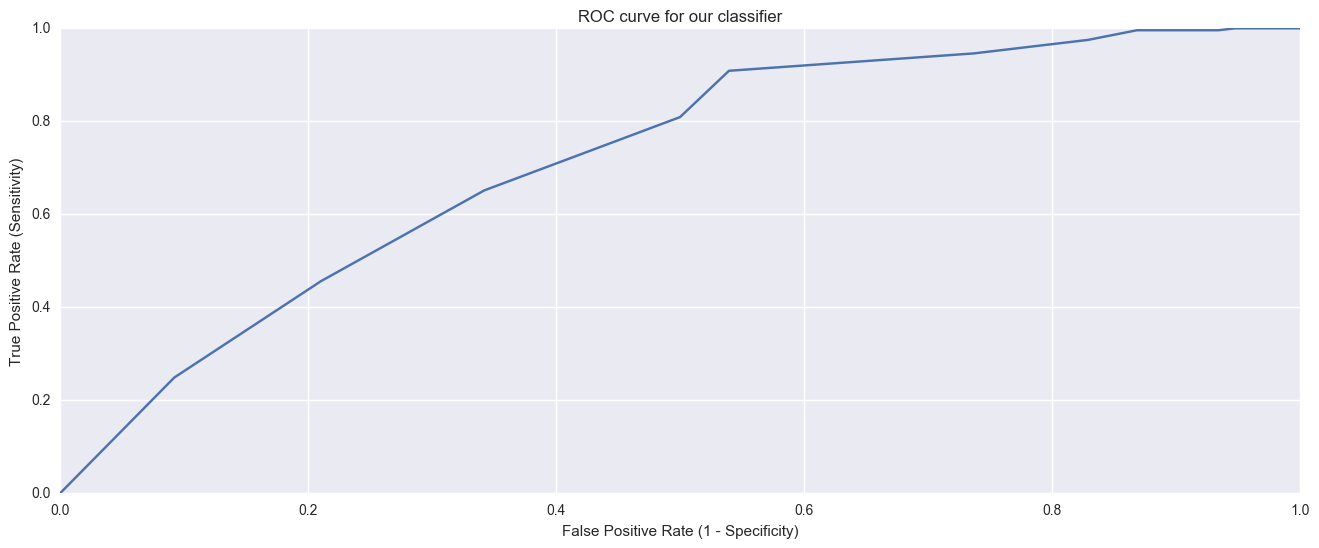

In [292]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr)
plt.title('ROC curve for our classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')

In [293]:
# calculate cross-validated AUC score
AUC_mean = cross_val_score(rfc, x, y, cv=10, scoring='roc_auc').mean()
print("AUC score :", AUC_mean)

AUC score : 0.703176583049


Ok, so what does this all mean.

First the ROC curve shows us what are the best compromises we can make between Specificity and Sensitivity (be aware that here specificity is inversed), with that you could chose precisely what you want the classifier to be compromising.

For the AUC score it shows a score of our model compared to a random sampling of 1's and 0's. (PS. the random sample is weighted of course)

Ok now we have all the tools to try and accuratly validate a method

Cross validation scores
[ 0.75471698  0.79874214  0.72955975  0.70440252  0.74213836  0.71518987
  0.74050633  0.76582278  0.79746835  0.74522293]
--------------------------
cross mean : 0.749377002014
cross min : 0.704402515723
cross max : 0.798742138365
----------
TN : 26 FP : 50
FN : 28 TP : 213
----------
specificity : 0.42
sensitivity or recall : 0.854053672316
precision : 0.823745900195


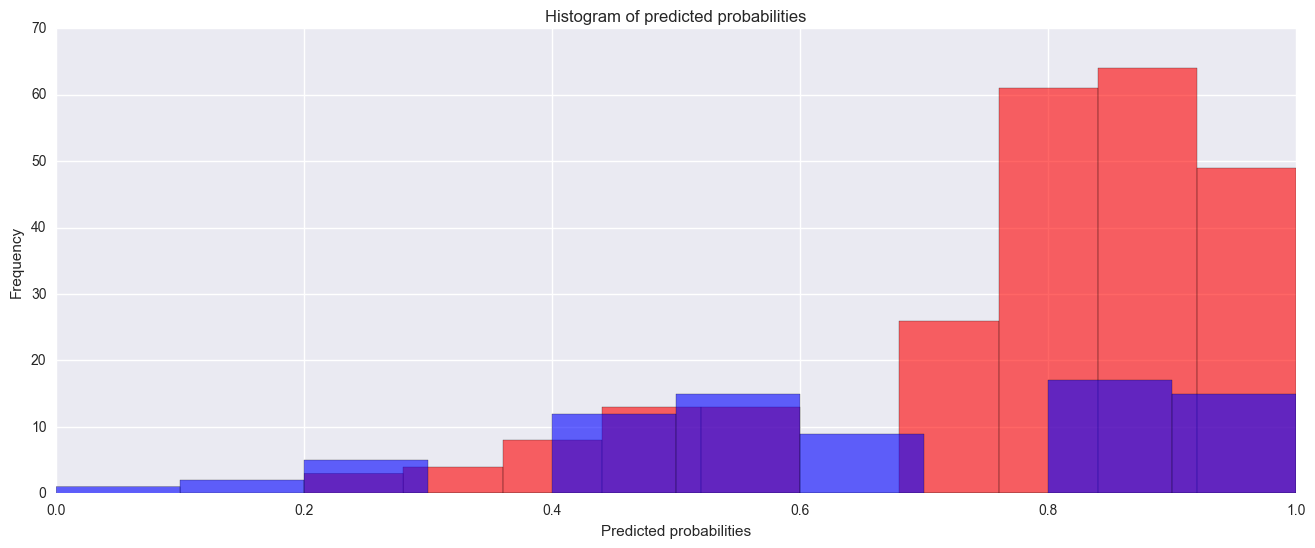

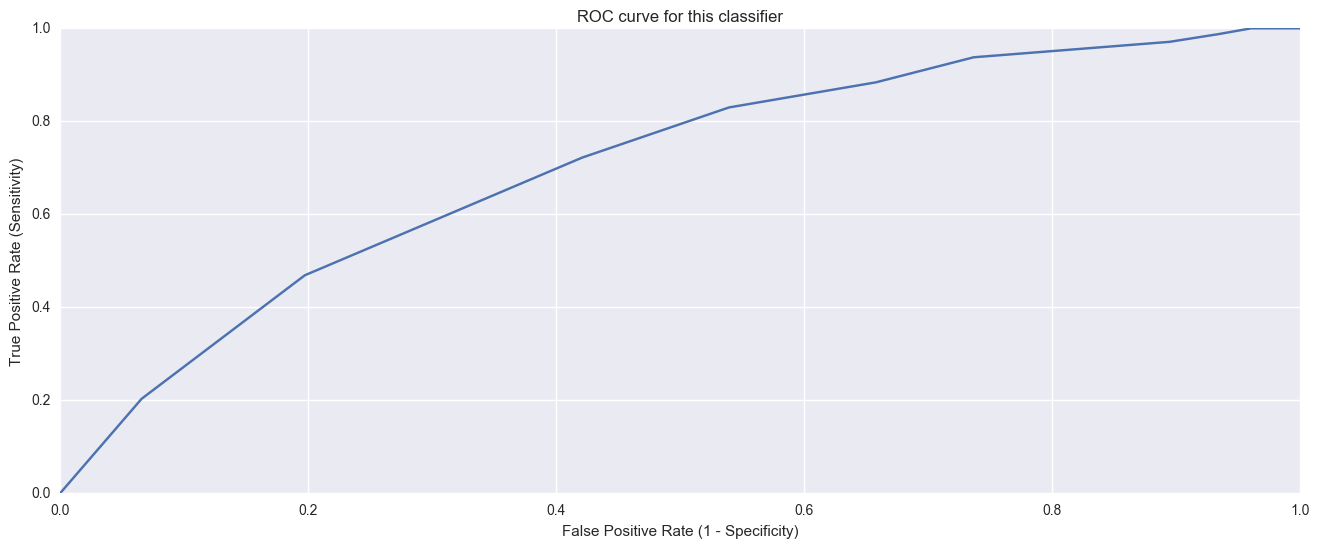

AUC score : 0.700888854867
f1 score : 0.700888854867


In [294]:
test_rfc_complete(rfc, x, y)

## Modifying the model

In this part we try to modify our model to have better result.

We have a lot of parameter to test for the random classifier, we selected two of them we think could change the results of the model.
 
The parameters we will test : 
  - n_estimators
  - max_features
  - max_depth

In [295]:
rfc = RFC(n_estimators=10, max_features=None, n_jobs=-1, class_weight=class_weights)

In [296]:
n_estimators_range = list(range(10,40))
max_features_range = uniform()
param_dist = dict(n_estimators=n_estimators_range, 
                  max_features=max_features_range)

In [297]:
rand = RandomizedSearchCV(rfc, param_dist, cv=20, scoring='roc_auc', n_iter=20, random_state=5)
rand.fit(x, y)

RandomizedSearchCV(cv=10, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True,
            class_weight={0: 0.24305555555555558, 1: 0.75694444444444442},
            criterion='gini', max_depth=None, max_features=None,
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params={}, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1083a8780>, 'n_estimators': [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39]},
          pre_dispatch='2*n_jobs', random_state=5, refit=True,
          return_train_score=True, scoring='roc_auc', verbose=0)

In [298]:
rand.best_params_

{'max_features': 0.35413804291500139, 'n_estimators': 26}

In [299]:
rand.best_score_

0.73796179364581072

After reading a bit more about the classifier (Sklearn doc) apparently sqrt as max_features works best for classification, let's test that and with log2 as we haave the option.

In [300]:
rfc = RFC(n_estimators=10, max_features="sqrt", n_jobs=-1, class_weight=class_weights)

In [301]:
n_estimators_range = list(range(20,40))
max_features_range = ["sqrt", "log2"]
max_depth_range = list(range(1, 20))
param_dist = dict(n_estimators=n_estimators_range, 
                  max_features=max_features_range,
                 max_depth=max_depth_range)

In [302]:
rand = RandomizedSearchCV(rfc, param_dist, cv=10, scoring='roc_auc', n_iter=20, random_state=5)
rand.fit(x, y)

RandomizedSearchCV(cv=10, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True,
            class_weight={0: 0.24305555555555558, 1: 0.75694444444444442},
            criterion='gini', max_depth=None, max_features='sqrt',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params={}, iid=True, n_iter=20, n_jobs=1,
          param_distributions={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], 'max_features': ['sqrt', 'log2'], 'n_estimators': [20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39]},
          pre_dispatch='2*n_jobs', random_state=5, refit=True,
          return_train_score=True, scoring='roc_auc', verbose=0)

In [303]:
#removed as not relevant and screen clutering if you're interested uncomment it
#rand.cv_results_

In [304]:
rand.best_params_

{'max_depth': 7, 'max_features': 'log2', 'n_estimators': 33}

In [305]:
rand.best_score_

0.74466216635818028

In [307]:
max_features_b = rand.best_params_["max_features"]
n_estimators_b = rand.best_params_["n_estimators"]
max_depth_b = rand.best_params_["max_depth"]

Cross validation scores
[ 0.75        0.8125      0.8125      0.8125      0.8         0.78481013
  0.75949367  0.7721519   0.78481013  0.81012658  0.75949367  0.84810127
  0.7721519   0.83544304  0.7721519   0.81012658  0.79746835  0.81012658
  0.75949367  0.80769231]
--------------------------
cross mean : 0.793557083739
cross min : 0.75
cross max : 0.848101265823
----------
TN : 9 FP : 67
FN : 1 TP : 240
----------
specificity : 0.209210526316
sensitivity or recall : 0.980805084746
precision : 0.794358491182


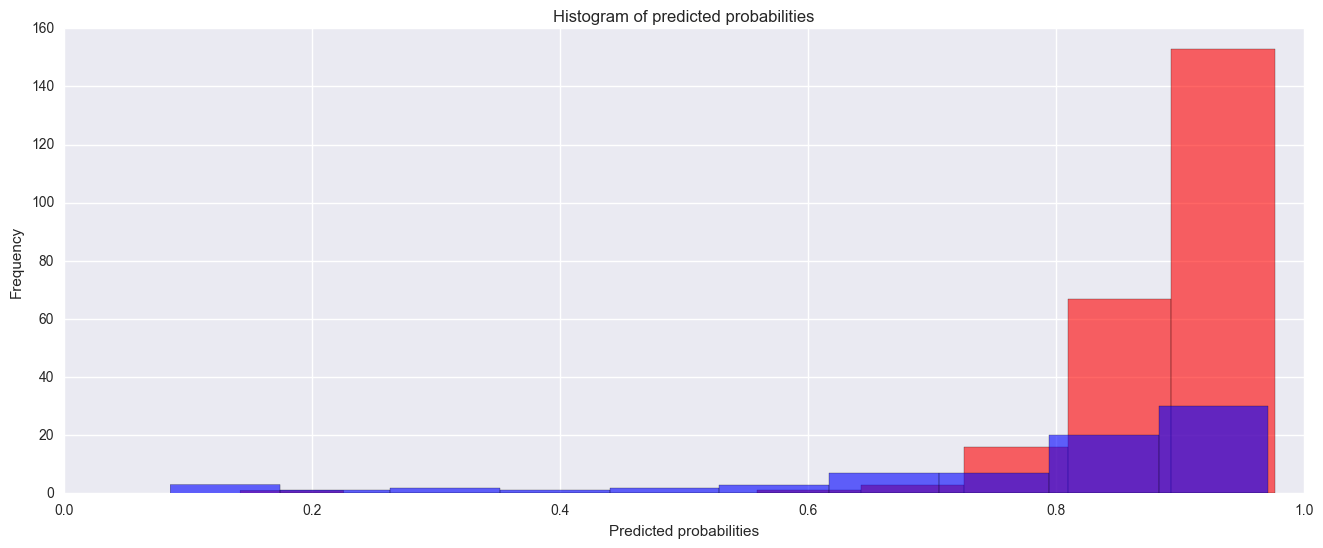

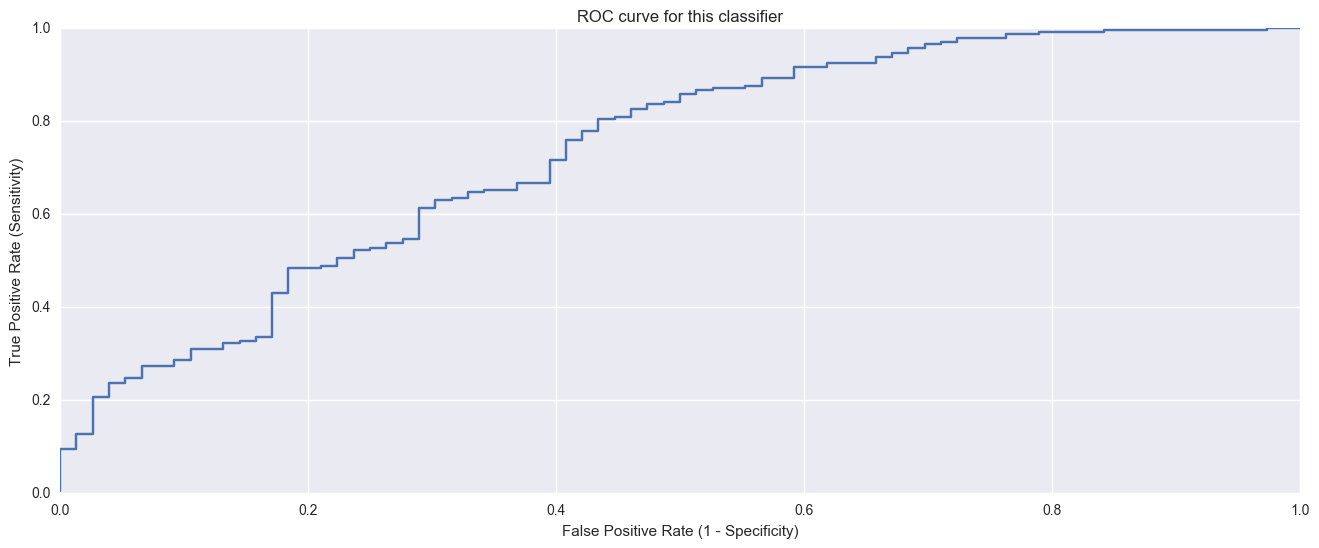

AUC score : 0.739248699078
f1 score : 0.739248699078


In [308]:
test_rfc_complete(RFC(max_features=max_features_b, n_estimators=n_estimators_b, max_depth=max_depth_b, n_jobs=-1, class_weight=class_weights), x, y)

We should have with this method the best AUC score we could have. Which is still not really an improvement... (we will reuse this method later) our accuracy went closer to 90% though

## Raters changes

As we said earlier in this notebook there are some things we can tune with the raters data we have. As we know the two raters have the following specificities :
- they rate differently
- they have values [0,0.25,0.5,0.75,1]

There are a few things we want to test : 
- a class for each possible value of the raters
- a class for < 0.5, > 0.5 and 0.5
- an independent learning for both raters
- only keeping the values where rater 1 and 2 are identical

We will test some different mix below

### A cluster for each value with independent raters

Here we will try predicting the 5 possible classes for one of the raters.

In [309]:
y_1 = (y_possible['rater1']).values

In [310]:
le = LabelEncoder()
le.fit(np.unique(y_1))
y_1 = le.transform(y_1)
y_1

array([1, 0, 1, ..., 3, 0, 0])

In [311]:
x_train, x_test, y_train, y_test = train_test_split(x, y_1, test_size=0.2, random_state=4)

We use the best parameters we found before (they may need a twist later as the model changes)

In [312]:
rfc = RFC(max_features=max_features_b, n_estimators=n_estimators_b, n_jobs=-1)

In [313]:
rfc.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='log2', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=33, n_jobs=-1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [314]:
y_pred = rfc.predict(x_test)

In [316]:
scores = cross_val_score(rfc, x, y, cv=20, scoring='accuracy')
show_score(scores)

[ 0.75        0.825       0.8125      0.825       0.7625      0.75949367
  0.74683544  0.81012658  0.7721519   0.73417722  0.7721519   0.83544304
  0.74683544  0.82278481  0.7721519   0.81012658  0.79746835  0.84810127
  0.78481013  0.80769231]
--------------------------
mean : 0.789767526777
min : 0.73417721519
max : 0.848101265823


For this method we decided to not go further as it is difficultly testable and the following method gave kind of similar results

We will not make an emphasis on this but here is the confusion matrix.

In [318]:
metrics.confusion_matrix(y_pred=y_pred, y_true=y_test)

array([[94, 31,  0,  1,  0],
       [49, 52,  4,  2,  0],
       [17, 22,  2,  1,  0],
       [10,  8,  3,  3,  5],
       [ 9,  1,  0,  3,  0]])

### 3 classes for values with a twist on the raters values

Let's look a bit more at the raters :

In [319]:
diff = [x[0] - x[1] for x in zip((y_possible['rater2']).values,(y_possible['rater1']).values) if not x[0] == x[1]]

In [320]:
diff = np.abs(diff)

In [321]:
np.unique(diff, return_counts=True)

(array([ 0.25,  0.5 ]), array([377,   2]))

We can see above that there are only small differences and 2 times where the difference is 0.5

With that we thought of doing this :
 - each time both raters are under 0.5 we put it in group 0
 - each time both raters are above 0.5 we put it in group 1
 - each time one rater is at 0.5 we look if the other falls in 0 or 1 and select that value
 - if both rating are 0.5 we put it in group 2
 - if both rating are between < 0.5 and > 0.5 we put it in group 3 

In [322]:
y_2 = []
for rate1, rate2 in zip((y_possible['rater2']).values,(y_possible['rater1']).values):
    if ((rate1 <= 0.5 and rate2 < 0.5) or (rate1 < 0.5 and rate2 <= 0.5)):
        y_2.append(1)
    elif ((rate1 >= 0.5 and rate2 > 0.5) or (rate1 > 0.5 and rate2 >= 0.5)):
        y_2.append(0)
    elif (rate1 == 0.5 or rate2 == 0.5):
        y_2.append(2)
    else :
        y_2.append(3)

In [323]:
np.unique(y_2, return_counts=True)

(array([0, 1, 2]), array([ 269, 1199,  116]))

We see here that the third group actually is never selected.

In [324]:
x_train, x_test, y_train, y_test = train_test_split(x, y_2, test_size=0.2, random_state=4)

We use the best parameters we found before.

In [325]:
rfc = RFC(max_features=max_features_b, n_estimators=n_estimators_b, n_jobs=-1)

In [326]:
scores = cross_val_score(rfc, x, y, cv=10, scoring='accuracy')
show_score(scores)

[ 0.77358491  0.83647799  0.76100629  0.76100629  0.80503145  0.79113924
  0.78481013  0.77848101  0.83544304  0.77707006]
--------------------------
mean : 0.790405039965
min : 0.761006289308
max : 0.836477987421


Here accuracy has not changed from before. Let's look at the confusion matrix.

In [327]:
# Prep of training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y_2, test_size=0.2, random_state=4)

In [328]:
# Do prediction for test values
rfc.fit(x_train, y_train)
y_pred = rfc.predict(x_test)

In [331]:
# Let's compute the convolution matrix
confusion_mx = metrics.confusion_matrix(y_test, y_pred)
confusion_mx

array([[ 19,  31,   0],
       [  9, 232,   0],
       [  1,  25,   0]])

With the confusion matrix, the first problem we see is that their was **no prediction for the class 2**. The second is that there is a lot of false positives and the actual sensitivity is :

In [332]:
confusion_mx[1,1] / (confusion_mx[0,1]  + confusion_mx[1,1] +confusion_mx[2,1])

0.80555555555555558

Which is worse than what we had before.

### last solution, change the threshold position

The intuition for this change is that we know that our classifier is better at predicting "lighter" players, therefore increasing the considered "light" players we should get better results in terms of accuracy. 

In [391]:
y_3 = ((y_possible['rater1'] + y_possible['rater2']) / 2 <= 0.5).values

In [392]:
x_train, x_test, y_train, y_test = train_test_split(x, y_3, test_size=0.2, random_state=4)

We know this is the best result we have, so let's find the best parameters we can.

In [393]:
prop1 = np.sum(y_3) / len(y_3)
prop0 = 1 - prop_1
class_weights = {
    0 : prop0,
    1 : prop1
}

In [394]:
prop1

0.83017676767676762

In [395]:
rfc = RFC(n_estimators=10, max_features="sqrt", n_jobs=-1, class_weight=class_weights)

In [396]:
n_estimators_range = list(range(20,40))
max_features_range = ["sqrt", "log2"]
max_depth_range = list(range(1, 20))
param_dist = dict(n_estimators=n_estimators_range, 
                  max_features=max_features_range,
                 max_depth=max_depth_range)

In [397]:
rand = RandomizedSearchCV(rfc, param_dist, cv=10, scoring='roc_auc', n_iter=20, random_state=5)
rand.fit(x, y_3)

RandomizedSearchCV(cv=10, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True,
            class_weight={0: 0.24305555555555558, 1: 0.83017676767676762},
            criterion='gini', max_depth=None, max_features='sqrt',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params={}, iid=True, n_iter=20, n_jobs=1,
          param_distributions={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], 'max_features': ['sqrt', 'log2'], 'n_estimators': [20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39]},
          pre_dispatch='2*n_jobs', random_state=5, refit=True,
          return_train_score=True, scoring='roc_auc', verbose=0)

In [398]:
#removed as not relevant and screen clutering if you're interested uncomment it
#rand.cv_results_

In [399]:
rand.best_params_

{'max_depth': 18, 'max_features': 'sqrt', 'n_estimators': 29}

In [400]:
rand.best_score_

0.77630592187721204

In [401]:
max_features_b = rand.best_params_["max_features"]
n_estimators_b = rand.best_params_["n_estimators"]
max_depth_b = rand.best_params_["max_depth"]

In [465]:
rfc = RFC(max_depth=max_depth_b, max_features=max_features_b, n_estimators=n_estimators_b, n_jobs=-1, class_weight=class_weights)

computing cross validation for accuracy
Cross validation scores
[ 0.7625      0.875       0.8625      0.875       0.8875      0.8375      0.825
  0.8375      0.8625      0.87341772  0.78481013  0.92405063  0.83544304
  0.87341772  0.82278481  0.88461538  0.82051282  0.88461538  0.83333333
  0.85897436]
--------------------------
cross mean : 0.851048766634
cross min : 0.7625
cross max : 0.924050632911
computing confusion matrix
----------
TN : 12 FP : 38
FN : 6 TP : 261
----------
computing cross validation for specificity
specificity : 0.301648351648
computing cross validation for recall
sensitivity or recall : 0.965839160839
computing cross validation for precision
precision : 0.873220337076


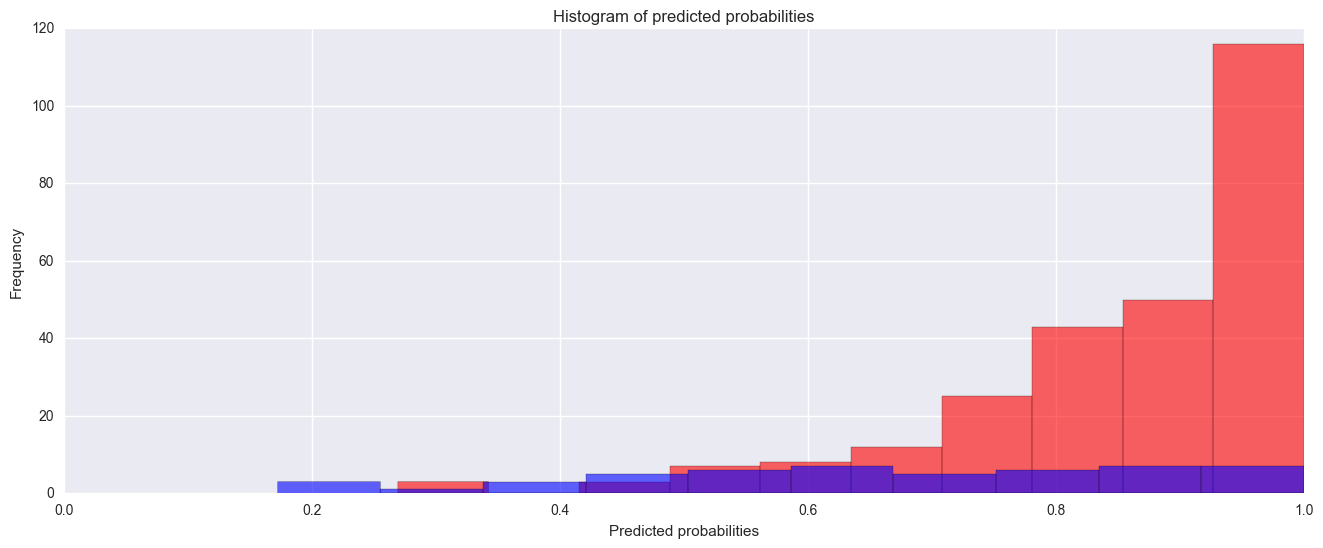

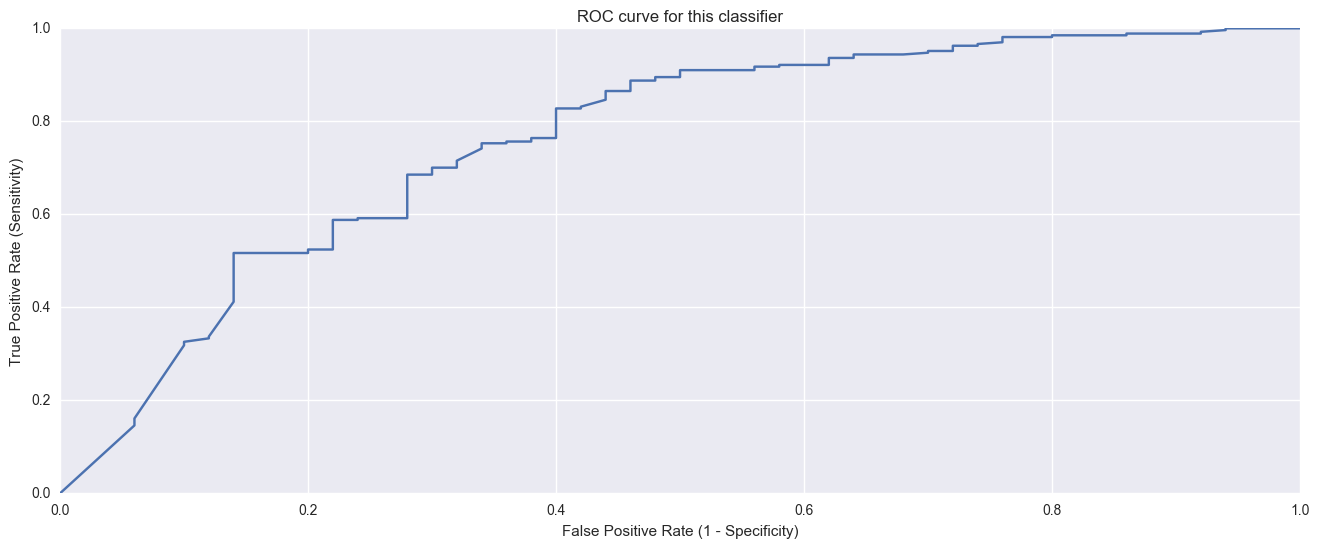

computing cross validation for AUC
AUC score : 0.7700043226
computing cross validation for f1_mean
f1 score : 0.7700043226


In [403]:
test_rfc_complete(rfc, x, y_3)

Ok here we have it, the best result we had so far. The AUC score is higher than ever before (~77%) ! With an accuracy of 85% we are also above all previously done tests. But if we look at specificity, it's not really better than before. However knowing the AUC score we know we can find a good compromise between the two. 

# Feature importance !

Let's look at the feature importance in our (for now) best classifier.

In [478]:
feature_names = x.columns.values
rfc.fit(x, y)
a = list(zip(feature_names, rfc.feature_importances_))
sorted(a, key=lambda x: -x[1])

[('seExp', 0.11062518676224946),
 ('seIAT', 0.10574238929575989),
 ('meanExp', 0.092236634680951432),
 ('meanIAT', 0.081519776441977318),
 ('birthday', 0.061356292880983668),
 ('victories', 0.054964402405454311),
 ('club', 0.054752760693185361),
 ('games', 0.053702333069826143),
 ('goals', 0.051861451479391335),
 ('defeats', 0.050852330096628144),
 ('ties', 0.04874327116700497),
 ('weight', 0.04329333278383253),
 ('yellowCards', 0.04030047759478194),
 ('height', 0.039913695087830152),
 ('position', 0.03476453082414601),
 ('leagueCountry', 0.029607201489304909),
 ('redCards', 0.02462292963920484),
 ('yellowReds', 0.021141003607487569)]

What we expected to see was that the features league country and club be an important factor. For example some clubs / country might be more inclined in having lighter players than another.

We surely did not expect the seExp and seMean be a factor if cards were not either. The algorithm could have associated a high meanExp with a lot of cards with a lot of matches with unfair referees. But that doesn't seem to be the case here.

As we don't know why they are so important why don't we remove se\* and mean\*.

In [479]:
x1 = x.drop(["meanExp", "meanIAT", "seIAT", "seExp"], axis=1)

First we need to know how well the classifier does now.

computing cross validation for accuracy
Cross validation scores
[ 0.85        0.8125      0.8         0.85        0.8375      0.8375      0.8
  0.8125      0.85        0.86075949  0.79746835  0.87341772  0.82278481
  0.84810127  0.84810127  0.87179487  0.82051282  0.85897436  0.84615385
  0.83333333]
--------------------------
cross mean : 0.836570107108
cross min : 0.79746835443
cross max : 0.873417721519
computing confusion matrix
----------
TN : 8 FP : 42
FN : 7 TP : 260
----------
computing cross validation for specificity
specificity : 0.145604395604
computing cross validation for recall
sensitivity or recall : 0.97337995338
computing cross validation for precision
precision : 0.845499159763


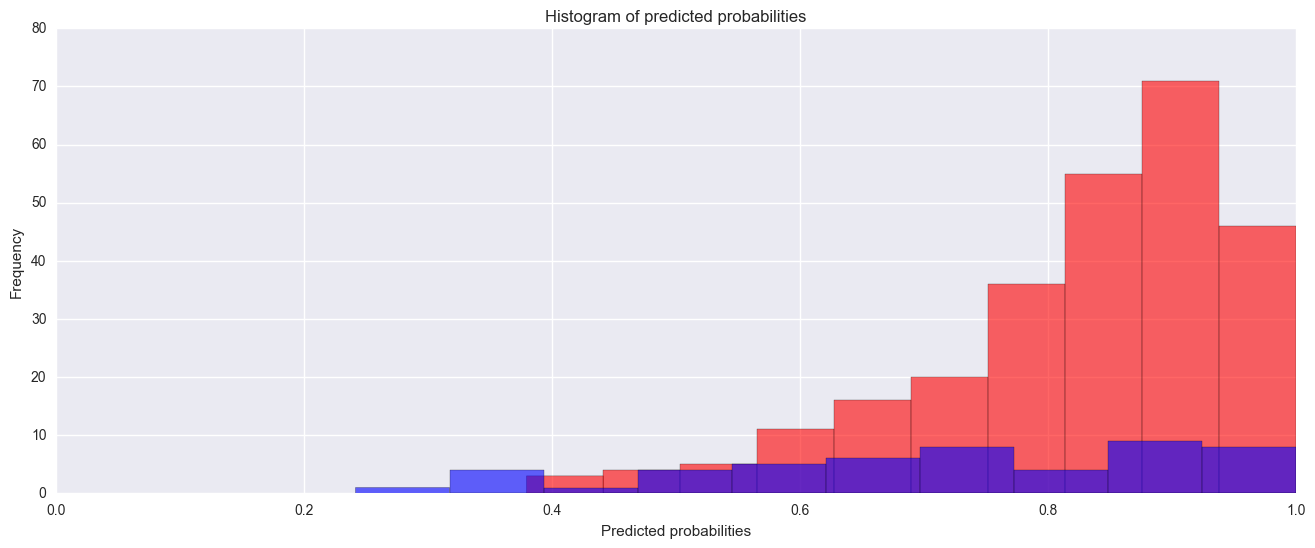

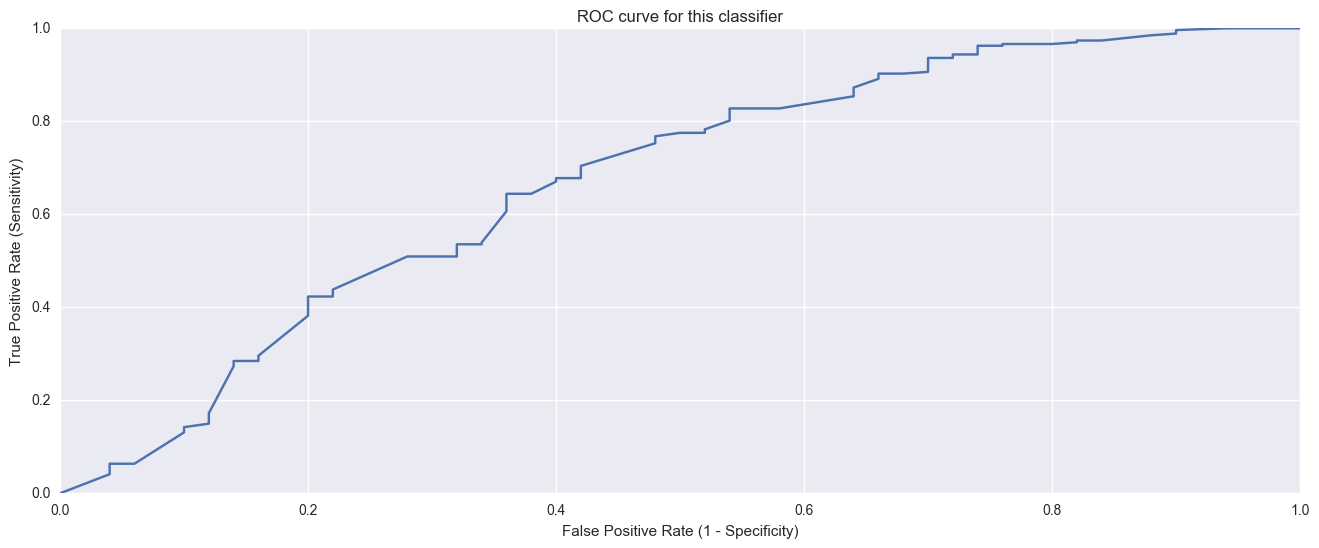

computing cross validation for AUC
AUC score : 0.690242962166
computing cross validation for f1_mean
f1 score : 0.690242962166


In [480]:
test_rfc_complete(rfc, x1, y)

As we can see this is a very bad prediction... so they must be important in a way.

In [469]:
feature_names = x1.columns.values
rfc.fit(x1, y)
a = list(zip(feature_names, rfc.feature_importances_))
sorted(a, key=lambda x: -x[1])

[('birthday', 0.10484165019988188),
 ('games', 0.10476125875878592),
 ('victories', 0.093739038863618895),
 ('goals', 0.087150952072927085),
 ('club', 0.084046865200352511),
 ('weight', 0.083916474770952515),
 ('ties', 0.078296115180134712),
 ('defeats', 0.071206495404216558),
 ('yellowCards', 0.069721069569643648),
 ('height', 0.066879197070499122),
 ('leagueCountry', 0.045034229794402594),
 ('position', 0.043500014455981145),
 ('redCards', 0.035776196794537099),
 ('yellowReds', 0.031130441864066306)]

Now we will remove some of the worst feature, which were certainly add variance therefore overfitting to our model. If one of our intuition was right (about the cards) we should have a change of feature importance by removing the card information.

In [470]:
x2 = x.drop(["redCards", "yellowReds"], axis=1)

computing cross validation for accuracy
Cross validation scores
[ 0.8         0.875       0.875       0.875       0.875       0.8375
  0.8375      0.8375      0.8875      0.88607595  0.78481013  0.91139241
  0.82278481  0.87341772  0.82278481  0.87179487  0.84615385  0.87179487
  0.83333333  0.87179487]
--------------------------
cross mean : 0.854806880883
cross min : 0.784810126582
cross max : 0.911392405063
computing confusion matrix
----------
TN : 11 FP : 39
FN : 8 TP : 259
----------
computing cross validation for specificity
specificity : 0.298076923077
computing cross validation for recall
sensitivity or recall : 0.96351981352
computing cross validation for precision
precision : 0.871735417795


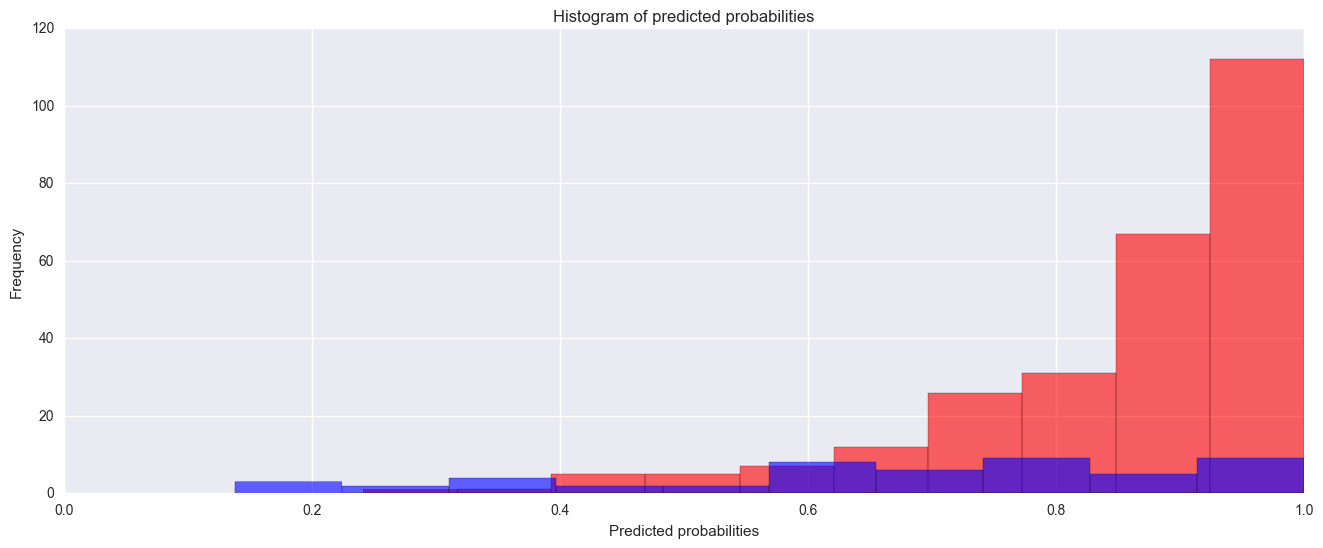

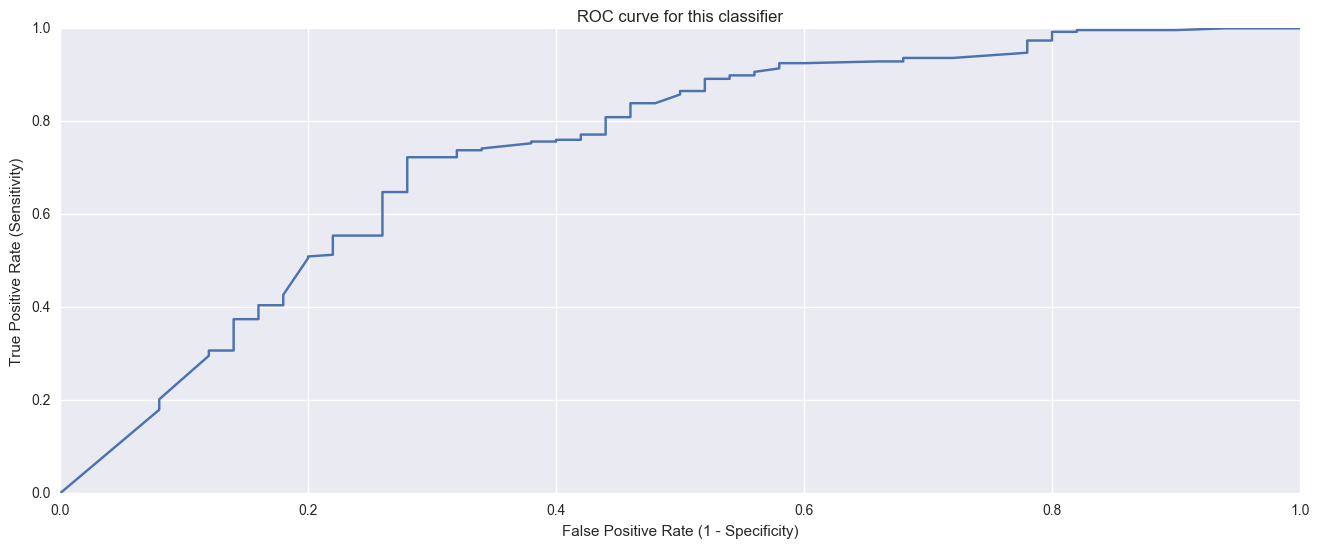

computing cross validation for AUC
AUC score : 0.766859774841
computing cross validation for f1_mean
f1 score : 0.766859774841


In [471]:
test_rfc_complete(rfc, x2, y)

This new version of the classifier does a pretty good yob with our first y (with 1 = mean(r1,r2) < 0.5)

Let's look at feature importance again :

In [472]:
feature_names = x2.columns.values
rfc.fit(x2, y)
a = list(zip(feature_names, rfc.feature_importances_))
sorted(a, key=lambda x: -x[1])

[('seIAT', 0.10817969126378871),
 ('meanExp', 0.10407572104866179),
 ('seExp', 0.10347545520786196),
 ('meanIAT', 0.091278826211543915),
 ('victories', 0.057506294589329675),
 ('goals', 0.057227034827798777),
 ('ties', 0.055261901793659168),
 ('birthday', 0.05486061766665444),
 ('games', 0.053428548970627668),
 ('yellowCards', 0.053072770479897495),
 ('defeats', 0.052143095650312409),
 ('club', 0.051727595885891306),
 ('weight', 0.047541633810151675),
 ('height', 0.044012568133788003),
 ('position', 0.034726626932169151),
 ('leagueCountry', 0.031481617527863812)]

We don't really see a change in the features we wanted to. But one feature clearly dropped down in importance : yellow cards. Wierdly enough what happens next is awesome.

First let's remove one of the less valuable features

In [473]:
x3 = x2.drop(["leagueCountry"], axis=1)

computing cross validation for accuracy
Cross validation scores
[ 0.7875      0.875       0.8875      0.875       0.8625      0.8625      0.85
  0.825       0.8625      0.88607595  0.81012658  0.92405063  0.83544304
  0.87341772  0.81012658  0.87179487  0.84615385  0.88461538  0.84615385
  0.85897436]
--------------------------
cross mean : 0.856721640701
cross min : 0.7875
cross max : 0.924050632911
computing confusion matrix
----------
TN : 11 FP : 39
FN : 8 TP : 259
----------
computing cross validation for specificity
specificity : 0.278846153846
computing cross validation for recall
sensitivity or recall : 0.96958041958
computing cross validation for precision
precision : 0.868957921505


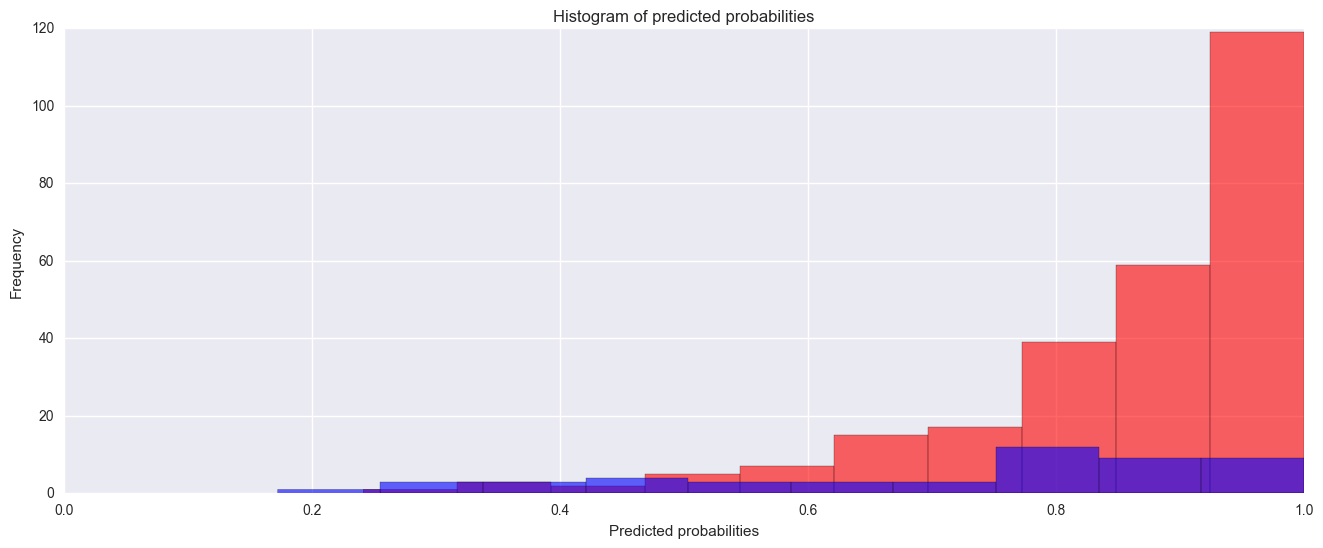

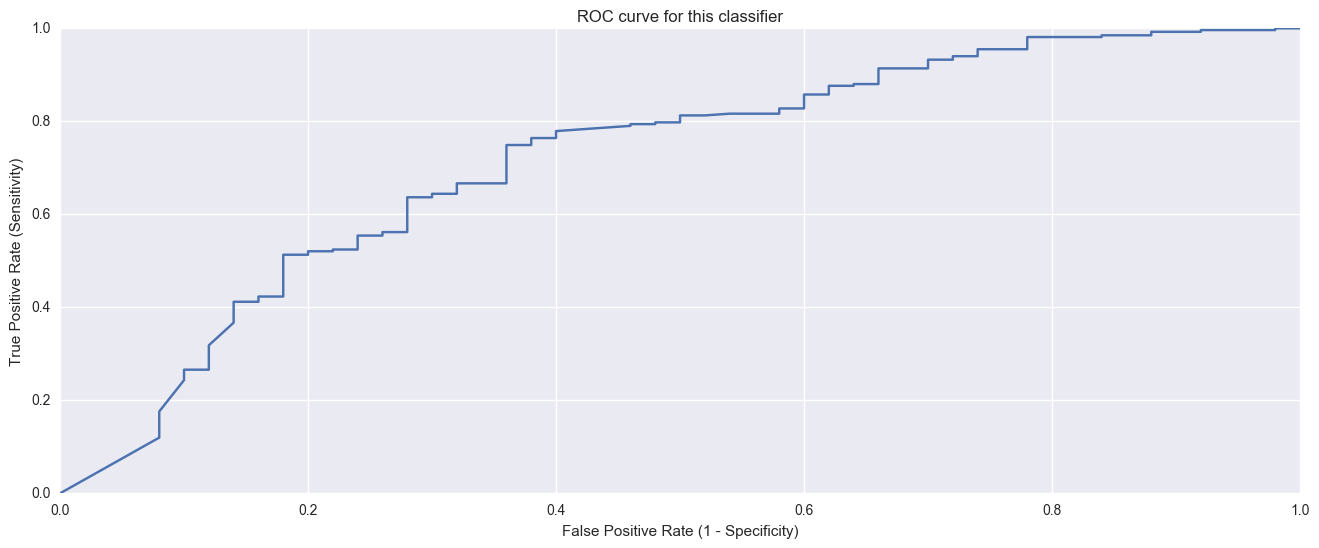

computing cross validation for AUC
AUC score : 0.764612118651
computing cross validation for f1_mean
f1 score : 0.764612118651


In [474]:
test_rfc_complete(rfc, x3, y)

we clearly see a drop in AUC and F1 score, now what happens if we remove yellow cards ?

In [475]:
x4 = x2.drop(["yellowCards"], axis=1)

computing cross validation for accuracy
Cross validation scores
[ 0.775       0.8875      0.8625      0.8875      0.875       0.8125      0.825
  0.825       0.8625      0.88607595  0.79746835  0.91139241  0.82278481
  0.87341772  0.81012658  0.88461538  0.80769231  0.85897436  0.84615385
  0.85897436]
--------------------------
cross mean : 0.84850880396
cross min : 0.775
cross max : 0.911392405063
computing confusion matrix
----------
TN : 11 FP : 39
FN : 5 TP : 262
----------
computing cross validation for specificity
specificity : 0.282417582418
computing cross validation for recall
sensitivity or recall : 0.967342657343
computing cross validation for precision
precision : 0.866561298304


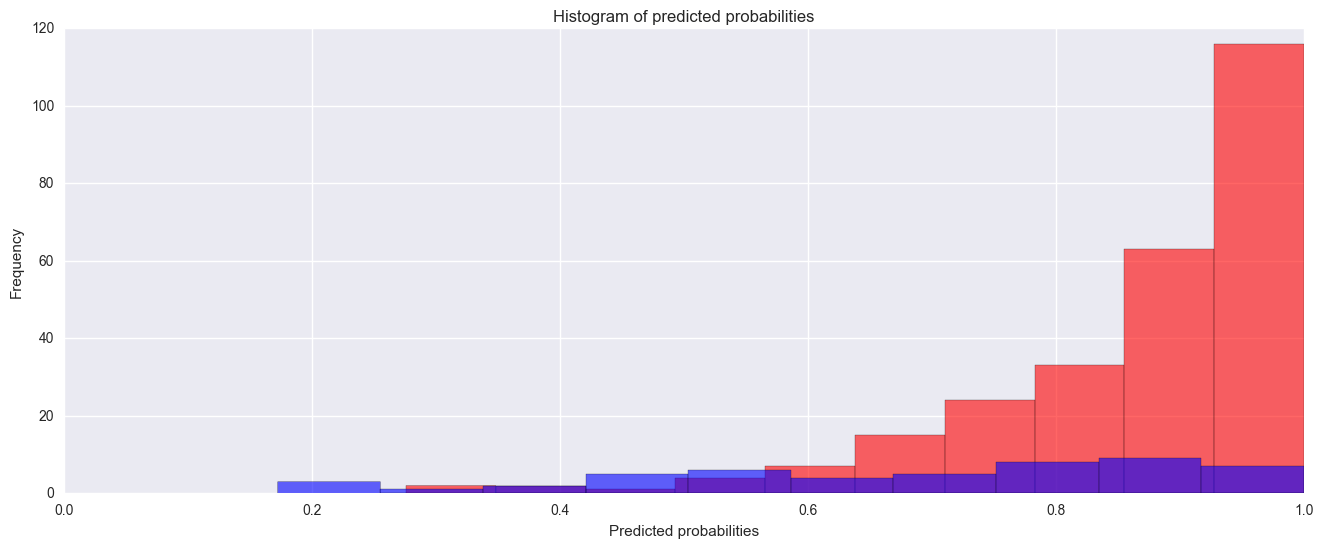

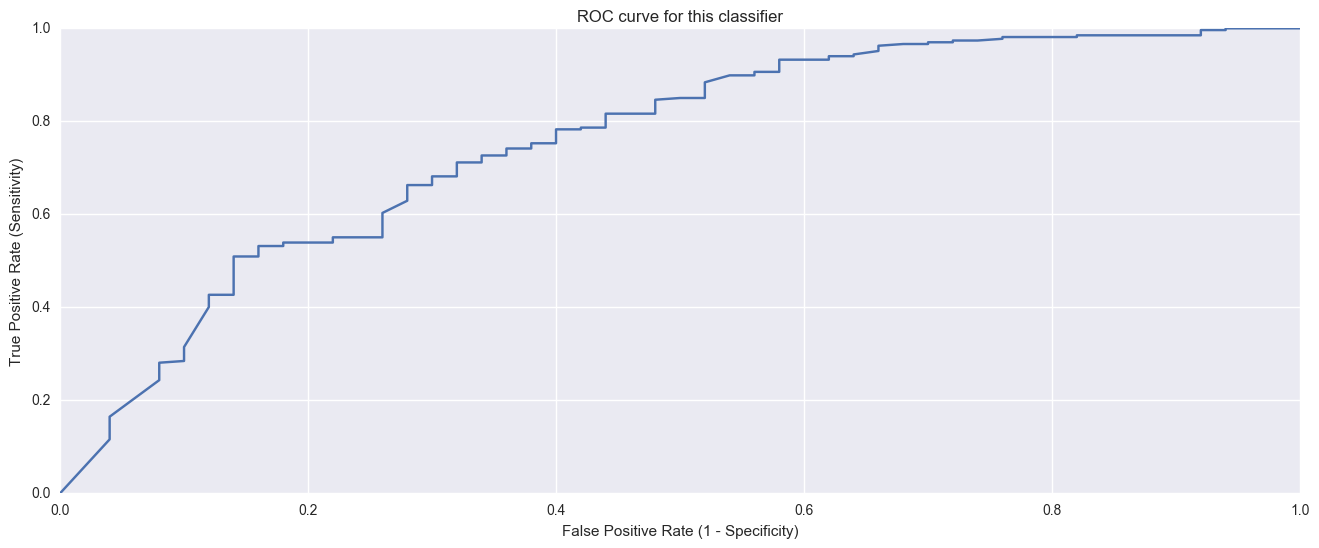

computing cross validation for AUC
AUC score : 0.752797555009
computing cross validation for f1_mean
f1 score : 0.752797555009


In [476]:
test_rfc_complete(rfc, x3, y)

As we can see the drop in AUC score is less than the one above ! 

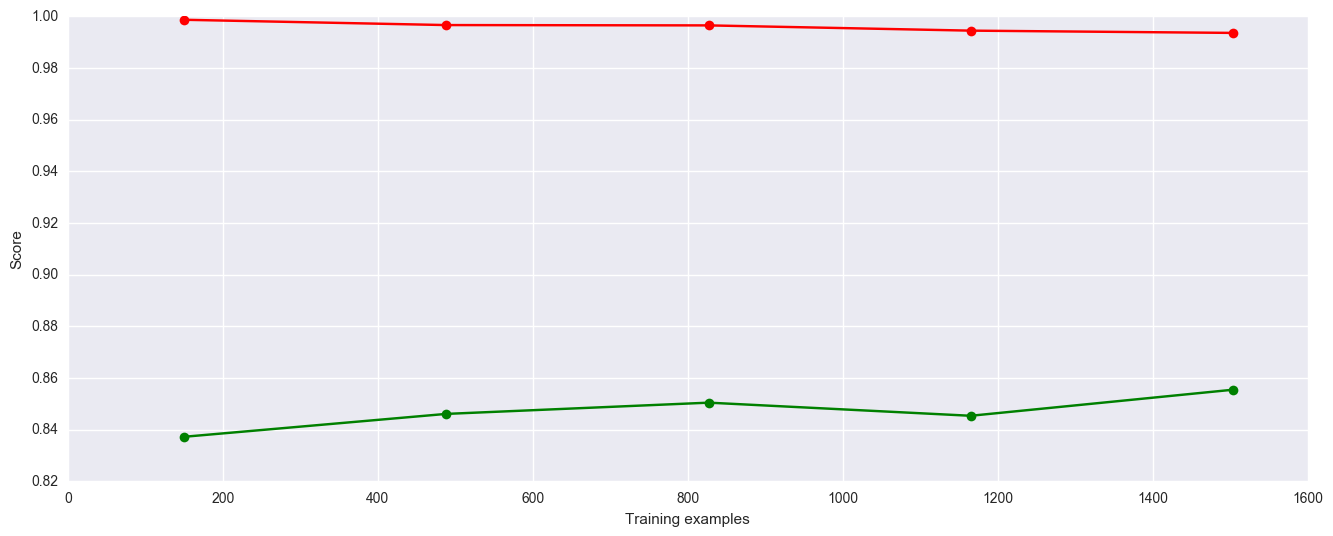

In [477]:
train_sizes, train_scores, test_scores = learning_curve(rfc, x4, y, cv=20, n_jobs=-1)
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure()
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")

# Learning curves ! ( Bonus )

As we were asked let's show the learning curves for our best estimator

In [347]:
y = y_3

In [349]:
rfc = RFC(max_depth=max_depth_b, max_features=max_features_b, n_estimators=n_estimators_b, n_jobs=-1, class_weight=class_weights)

In [350]:
train_sizes, train_scores, test_scores = learning_curve(rfc, x, y, cv=20, n_jobs=-1)
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

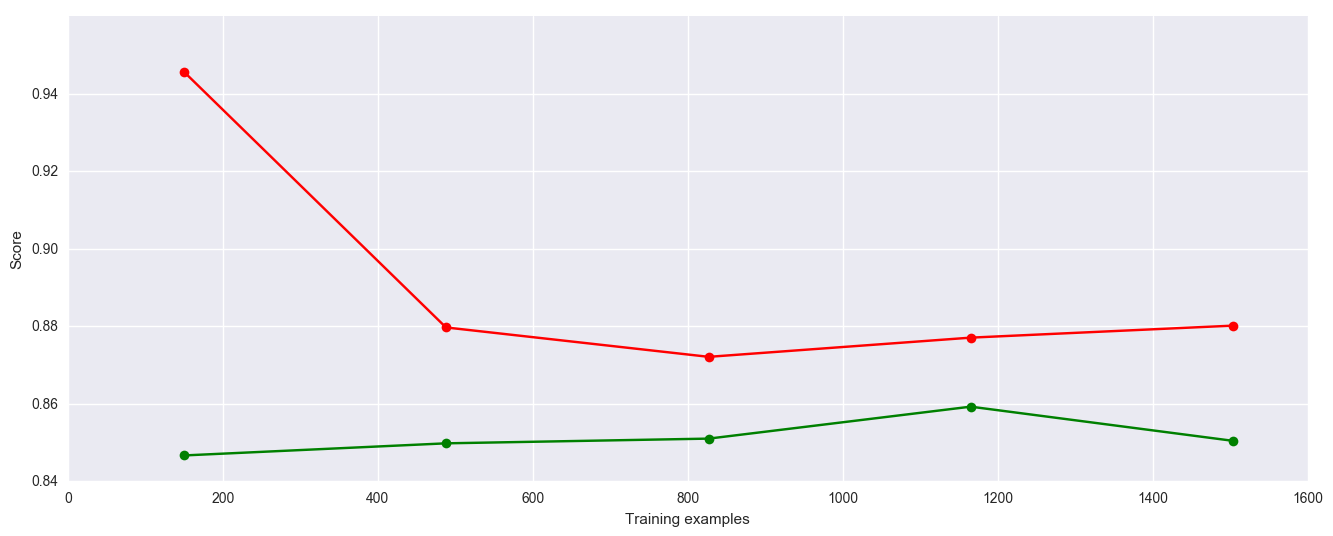

In [351]:
plt.figure()
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")

Let's now look at what the change of some parameters does to the curves :

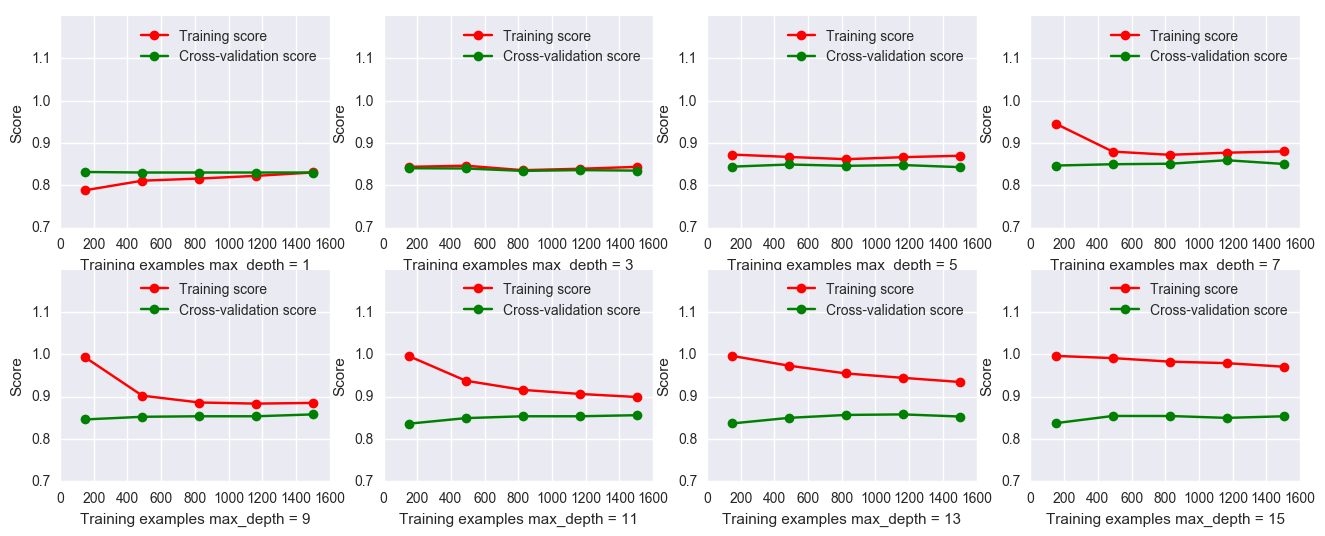

In [353]:
for i,max_depth in enumerate(range(1, 16, 2)):
    rfc = RFC(max_features=max_features_b, n_estimators=n_estimators_b, max_depth=max_depth, n_jobs=-1, class_weight=class_weights)
    train_sizes, train_scores, test_scores = learning_curve(rfc, x, y, cv=20, n_jobs=-1)
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    
    plt.subplot(2, 4, i+1)
    
    plt.xlim(0, 1600)
    plt.ylim(0.7, 1.2) # trick to better see the labels.

    plt.xlabel("Training examples max_depth = " + str(max_depth))
    plt.ylabel("Score")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend()

plt.show()


We see here exactly what we were looking for : at first we have high biais and as we increase the max_depth the biais diminishes until we have really high variance.

Of course this is not the case for all parameters, let's look at n_estimators for example.

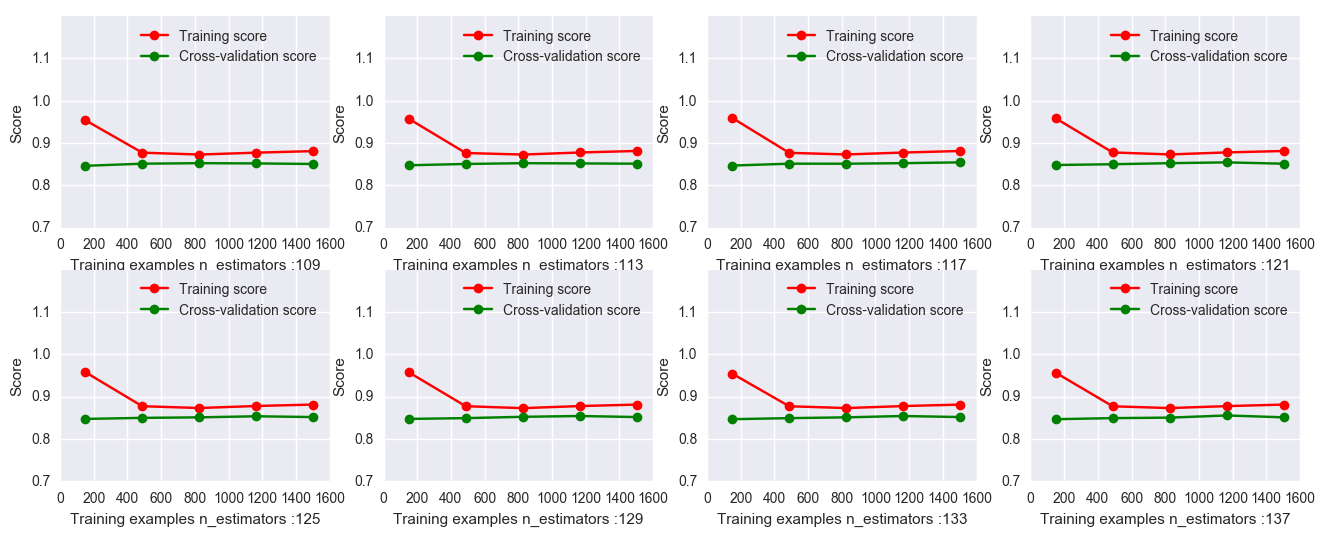

In [355]:
for i,n_estimators in enumerate(range(109, 139, 4)):
    rfc = RFC(max_depth=max_depth_b, max_features=max_features_b, n_estimators=n_estimators, n_jobs=-1, class_weight=class_weights)
    train_sizes, train_scores, test_scores = learning_curve(rfc, x, y, cv=20, n_jobs=-1)
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    
    plt.subplot(2, 4, i+1)
    
    plt.xlim(0, 1600)
    plt.ylim(0.7, 1.2) # trick to better see the labels.

    plt.xlabel("Training examples n_estimators :" + str(n_estimators))
    plt.ylabel("Score")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend()
    
plt.show()
